In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch_v2 import Net
# from compare_performance import compare_performance
from branch_NPP23 import Net_NPP23
from galerkin import DGMNet
from bsde import BSDENet
import logging

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu124
torchaudio version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Sat Nov 23 09:45:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               Off |   00000000:21:00.0  On |                  Off |
| 41%   39C    P8             18W /  140W |    7422MiB /  16376MiB |     20%      Default |
|                                         |                        |                  N/A |
+-------------

In [4]:
def simulate_mc_and_plot(model, problem_name, exact_example=None, nb_spatial=10, repeats=1, return_mc=False, plt_and_save=True):
    start = time.time()
    tx = torch.zeros(nb_spatial, dim + 1, device=device)
    tx[:, -1] = torch.linspace(x_lo, x_hi, nb_spatial)
    mc = 0
    for _ in range(repeats):
        x, y = model.gen_sample_mc(patch=0, tx=tx)
        mc += y.cpu()
    mc /= repeats
    
    # original grid for mc
    mc_grid = tx[:, -1].cpu()
    # can't plot & save when exact_example is not given
    plt_and_save = False if exact_example is None else plt_and_save
    if plt_and_save:
         # finer grid for exact solution
        x = np.zeros((dim, 10 * nb_spatial))
        exact_grid = np.linspace(model.x_lo, model.x_hi, 10 * nb_spatial)
        x[-1] = exact_grid

        # plot
        plt.scatter(mc_grid, mc, s=50, facecolors='none', edgecolors='black', label='MC')
        exact = exact_example(t=0, x=x, T=T)
        terminal = exact_example(t=T, x=x, T=T)
        plt.plot(exact_grid, exact, color='purple', label='exact')
        plt.plot(exact_grid, terminal, '--',color='blue', label='terminal')
        plt.legend()
        plt.grid()
        fname = f"simulate_mc_{problem_name}_dim_{dim}" if problem_name is not None else f"demo_dim_{dim}"
        plt.savefig(f"plot/{'simulate_mc_' if fname is None else fname}.pdf")
        plt.show()

        np.savetxt(
            "log/plt_" + problem_name + "_fine.csv",
            np.stack((exact_grid, exact, terminal), axis=-1),
            delimiter=",",
            header="x, true, terminal",
            comments="",
        )
        np.savetxt(
            "log/plt_" + problem_name + "_coarse.csv",
            np.stack((mc_grid, torch.flatten(mc)), axis=-1),
            delimiter=",",
            header="x, branch",
            comments="",
        )
    print(f"Time taken: {time.time() - start:.0f} seconds.")
    if return_mc:
        return mc_grid, mc

## Exponential Nonlinearity in dimension d = 1 - Space plot with T = 0.5

In [5]:
fixed_dim, dim = 0, 1

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example2(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4 * torch.exp(-y) - 10 * torch.exp(- y / 2) + torch.exp( y / 2) - torch.exp( y )

def f_example(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4 * torch.exp(-y[0]) - 10 * torch.exp(- y[0] / 2) + torch.exp( y[0] / 2) - torch.exp( y[0] )

def phi_example(x):
    return 2* torch.log(1 + 1 / ( 1 + torch.exp(x.sum(dim=0) / math.sqrt(dim) )))

def exact_example(t, x, T):
    return 2*np.log(1 + 1/(1 + np.exp(x.sum(axis=0)/np.sqrt(dim) - (T - t))))

def g_fun(x):
    return 2*torch.log(1 + 1/(1 + torch.exp(x.sum(dim=0)/np.sqrt(dim))));

t_lo, t_hi, x_lo, x_hi, n = 0., 0.5, -7.*math.sqrt(dim), 7.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0


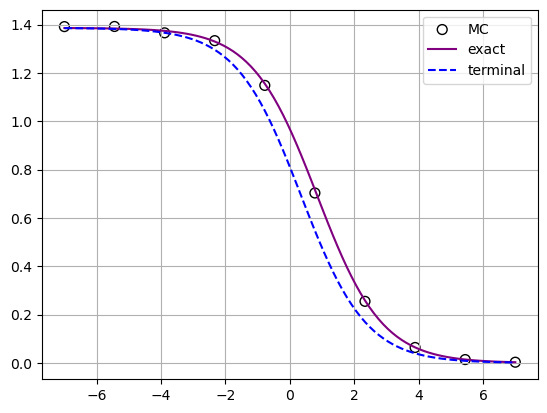

Time taken: 96 seconds.


In [6]:
# define NN and train
seed=0
torch.manual_seed(seed)
print(
f"#### Starting deep branching method with seed {seed}"
)
problem_name="exp_example"

model=Net(    
    t_lo=t_lo, t_hi=t_lo,
    f_fun2=f_example2, 
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    branch_nb_states=1, 
    branch_nb_path_per_state=1, 
    branch_nb_states_per_batch=1,
    save_as_tmp=True,
)

simulate_mc_and_plot(model, problem_name="exp_example", repeats = 10000, exact_example=exact_example)

## Exponential Nonlinearity in dimension d = 10 - Space plot with T = 0.5

In [7]:
fixed_dim, dim = 0, 10

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)

t_lo, t_hi, x_lo, x_hi, n = 0., 0.5, -7.*math.sqrt(dim), 7.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0


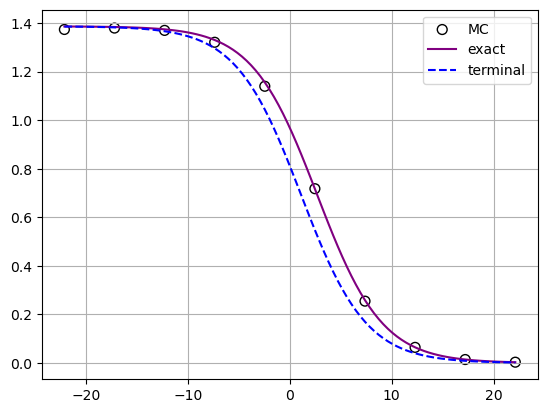

Time taken: 220 seconds.


In [8]:
# define NN and train
seed=0
torch.manual_seed(seed)
print(
f"#### Starting deep branching method with seed {seed}"
)
problem_name="exp_example"

model=Net(    
    t_lo=t_lo, t_hi=t_lo,
    f_fun2=f_example2, 
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    branch_nb_states=1, 
    branch_nb_path_per_state=1, 
    branch_nb_states_per_batch=1,
    save_as_tmp=True,
)

simulate_mc_and_plot(model, problem_name="exp_example", repeats = 10000, exact_example=exact_example)

## Allen-Cahn Equation in dimension d = 5 - Space plot with T = 0.5

In [9]:
fixed_dim, dim = 0, 5

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example2(y):
    """
    idx 0 -> no deriv
    """
    return y - y ** 3

def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

def g_fun(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

t_lo, t_hi, x_lo, x_hi, n = 0., 0.5, -7.*math.sqrt(dim), 7.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0


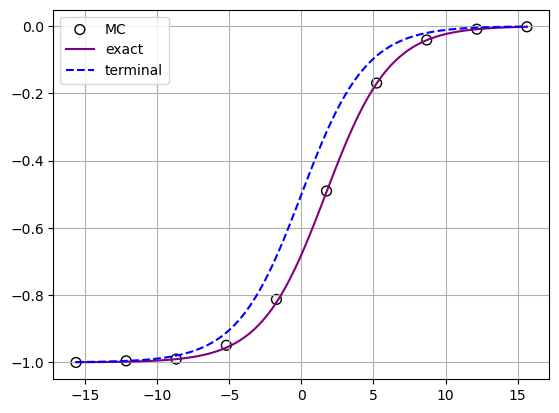

Time taken: 1414 seconds.


In [10]:
# define NN and train
seed=0
torch.manual_seed(seed)
print(
f"#### Starting deep branching method with seed {seed}"
)
problem_name="allen-cahn"

model = Net(
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=phi_example,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        device=device,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        verbose=True,
)
simulate_mc_and_plot(model, problem_name="allen-cahn", repeats = 100000, exact_example=exact_example)

## Allen-Cahn Equation in dimension d = 10 - Space plot with T = 0.5

In [11]:
fixed_dim, dim = 0, 10

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)

t_lo, t_hi, x_lo, x_hi, n = 0., 0.5, -7.*math.sqrt(dim), 7.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0


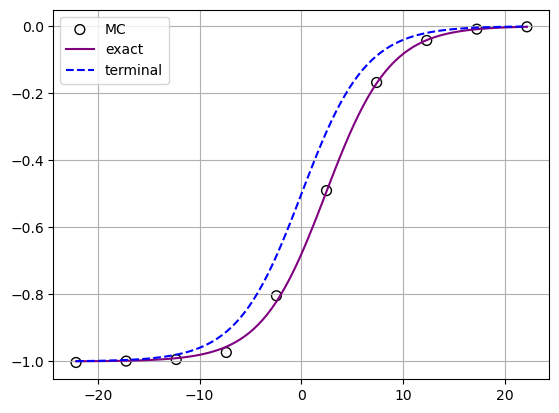

Time taken: 1991 seconds.


In [12]:
# define NN and train
seed=0
torch.manual_seed(seed)
print(
f"#### Starting deep branching method with seed {seed}"
)
problem_name="allen-cahn"

model = Net(
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=phi_example,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        device=device,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        verbose=True,
)
simulate_mc_and_plot(model, problem_name="allen-cahn", repeats = 100000, exact_example=exact_example)

In [13]:
def simulate_mc_time_and_plot(model, problem_name, exact_example=None, nb_spatial=1, nb_time=10, repeats=1, return_mc=False, plt_and_save=True):
    tx = torch.zeros(nb_spatial, dim + 1, device=device)
    tx[:, -1] = torch.linspace(x_lo, x_hi, nb_spatial)
    ttx = torch.zeros(nb_time, 1 + 1, device=device)
    ttx[:, -1] = torch.linspace(t_lo, t_hi, nb_time)
    start = time.time()
    mc = 0; 
    for _ in range(repeats):
        x, y = model.gen_sample_mc_time(patch=0, tx=tx, ttx=ttx,t_lo=t_lo,t_hi=t_hi, nb_time=nb_time)
        mc += y.cpu()
    mc /= repeats
    print(f"Time taken branch: {time.time() - start:.0f} seconds.")  

    start = time.time()
    mc_NPP23 = 0
    for _ in range(repeats):
        x, y = model_NPP23.gen_sample_mc_time(patch=0, tx=tx, ttx=ttx,t_lo=t_lo,t_hi=t_hi, nb_time=nb_time)
        mc_NPP23 += y.cpu()
    mc_NPP23 /= repeats
    print(f"Time taken NPP23 branch: {time.time() - start:.0f} seconds.")  
    # original grid for mc
    mc_grid = ttx[:, -1].cpu()
    # can't plot & save when exact_example is not given
    plt_and_save = False if exact_example is None else plt_and_save
    if plt_and_save:
         # finer grid for exact solution
        x = np.zeros((dim, 10 * nb_time))
        t = np.zeros((1, 10 * nb_time))
        exact_grid = np.linspace(model.t_lo, model.t_hi, 10 * nb_time)
        t[-1] = exact_grid
        # plot
        plt.scatter(mc_grid, mc, s=50, facecolors='none', edgecolors='black', label='MC')
        plt.scatter(mc_grid, mc_NPP23, s=50, facecolors='none', edgecolors='red', label='MC_NPP23')
        exact = exact_example(t=0, x=x, T=t)
        terminal = exact_example(t=0, x=x, T=t)
        plt.plot(exact_grid, exact[-1], color='purple', label='exact')
        plt.plot(exact_grid, terminal[-1], '--',color='blue', label='terminal')
        plt.legend()
        plt.grid()
        fname = f"simulate_mc_time_{problem_name}_dim_{dim}_samples_{repeats}" if problem_name is not None else f"demo_dim_{dim}"
        plt.savefig(f"plot/{'simulate_mc_time_' if fname is None else fname}.pdf")
        plt.show()

        np.savetxt(
            "log/plt_" + problem_name + "_time_fine.csv",
            np.stack((exact_grid, exact[-1], terminal[-1]), axis=-1),
            delimiter=",",
            header="x, true, terminal",
            comments="",
        )
        np.savetxt(
            "log/plt_" + problem_name + "_time_coarse.csv",
            np.stack((mc_grid, torch.flatten(mc)), axis=-1),
            delimiter=",",
            header="x, branch",
            comments="",
        )
    if return_mc:
        return mc_grid, mc

## Exponential Nonlinearity in dimension d = 1 - Time plot

In [14]:
fixed_dim, dim = 0, 1

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example2(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4 * torch.exp(-y) - 10 * torch.exp(- y / 2) + torch.exp( y / 2) - torch.exp( y )

def f_example(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4 * torch.exp(-y[0]) - 10 * torch.exp(- y[0] / 2) + torch.exp( y[0] / 2) - torch.exp( y[0] )

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to n -> second deriv
    """
    return .5 * y[1:].sum(axis=0) + 6 + 4 * torch.exp(-y[0]) - 10 * torch.exp(- y[0] / 2) + torch.exp( y[0] / 2) - torch.exp( y[0] ) 

def phi_example(x):
    return 2* torch.log(1 + 1 / ( 1 + torch.exp(x.sum(dim=0) / math.sqrt(dim) )))

def exact_example(t, x, T):
    return 2*np.log(1 + 1/(1 + np.exp(x.sum(axis=0)/np.sqrt(dim) - (T - t))))

def g_fun(x):
    return 2*torch.log(1 + 1/(1 + torch.exp(x.sum(dim=0)/np.sqrt(dim))));

t_lo, t_hi, x_lo, x_hi, n = 0., 1, -0., 0., 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0
Time taken branch: 115 seconds.
Time taken NPP23 branch: 115 seconds.


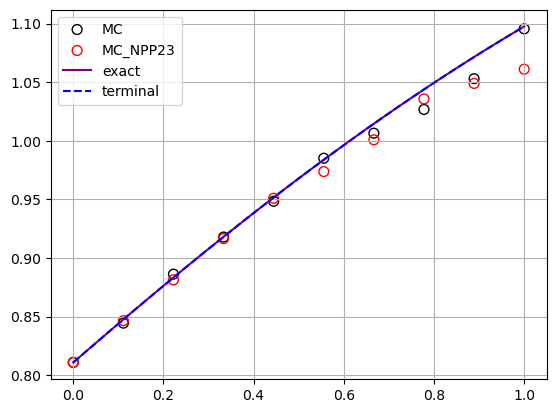

In [15]:
# define NN and train
seed=0
torch.manual_seed(seed)
print(
f"#### Starting deep branching method with seed {seed}"
)
problem_name="exp_example"

model = Net(
        t_lo=t_lo, t_hi=t_hi,
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=phi_example,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        device=device,
        verbose=True,
        save_as_tmp=True,
)
model_NPP23 = Net(
        t_lo=t_lo, t_hi=t_hi,
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=phi_example,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        device=device,
        save_as_tmp=True,
)

simulate_mc_time_and_plot(model, problem_name="exp_example", repeats = 10000, exact_example=exact_example)

## Exponential Nonlinearity in dimension d = 10 - Time plot

In [16]:
fixed_dim, dim = 0, 10

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)

t_lo, t_hi, x_lo, x_hi, n = 0., 1, -0., 0., 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0
Time taken branch: 2793 seconds.
Time taken NPP23 branch: 2806 seconds.


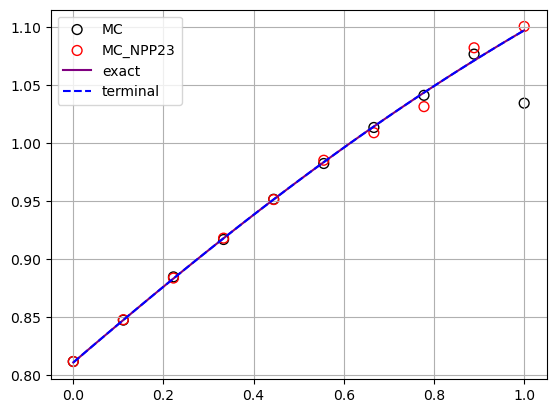

In [17]:
# define NN and train
seed=0
torch.manual_seed(seed)
print(
f"#### Starting deep branching method with seed {seed}"
)
problem_name="exp_example"

model = Net(
        t_lo=t_lo, t_hi=t_hi,
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=phi_example,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        device=device,
        verbose=True,
        save_as_tmp=True,
)
model_NPP23 = Net(
        t_lo=t_lo, t_hi=t_hi,
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=phi_example,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        device=device,
        save_as_tmp=True,
)

simulate_mc_time_and_plot(model, problem_name="exp_example", repeats = 100000, exact_example=exact_example)

## Allen-Cahn Equation in dimension d = 1 - Time plot

In [18]:
fixed_dim, dim = 0, 1

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example2(y):
    """
    idx 0 -> no deriv
    """
    return y - y ** 3

def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to n -> second deriv
    """
    return .5 * y[1:].sum(axis=0) + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

def g_fun(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

t_lo, t_hi, x_lo, x_hi, n = 0., 1, -0., 0., 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0
Time taken branch: 98 seconds.
Time taken NPP23 branch: 99 seconds.


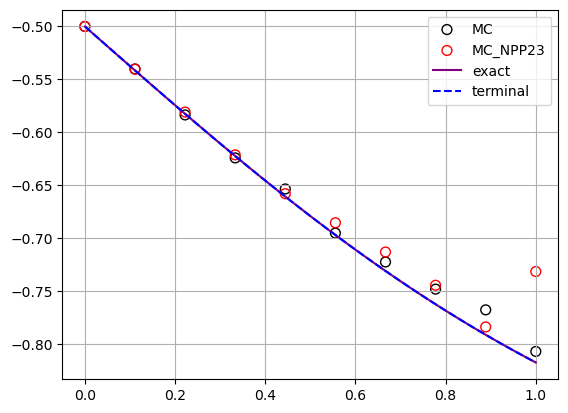

In [19]:
# define NN and train
seed=0
torch.manual_seed(seed)
print(
f"#### Starting deep branching method with seed {seed}"
)
problem_name="allen-cahn"
start = time.time()

model = Net(
        t_lo=t_lo, t_hi=t_hi,
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=g_fun,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        device=device,
        verbose=True,
        save_as_tmp=True,
)
model_NPP23 = Net(
        t_lo=t_lo, t_hi=t_hi,
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=g_fun,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        device=device,
        save_as_tmp=True,
)

simulate_mc_time_and_plot(model, problem_name="allen-cahn", repeats = 10000, exact_example=exact_example)

## Allen-Cahn Equation in dimension d = 10 - Time plot

In [20]:
fixed_dim, dim = 0, 10

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)

t_lo, t_hi, x_lo, x_hi, n = 0., 1, -0., 0., 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0
Time taken branch: 2552 seconds.
Time taken NPP23 branch: 2520 seconds.


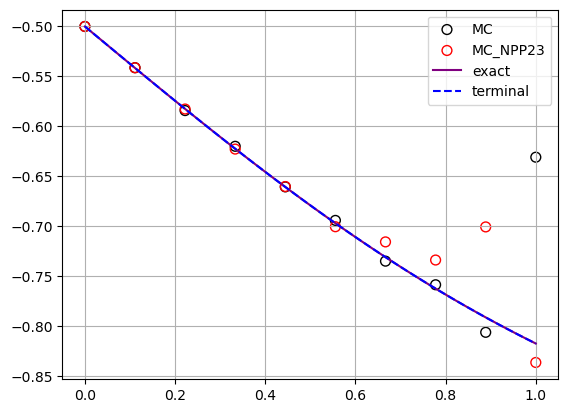

In [21]:
# define NN and train
seed=0
torch.manual_seed(seed)
print(
f"#### Starting deep branching method with seed {seed}"
)
problem_name="allen-cahn"
start = time.time()

model = Net(
        t_lo=t_lo, t_hi=t_hi,
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=g_fun,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        device=device,
        verbose=True,
        save_as_tmp=True,
)
model_NPP23 = Net(
        t_lo=t_lo, t_hi=t_hi,
        deriv_map=deriv_map,
        f_fun2=f_example2,
        phi_fun=g_fun,
        T=T,
        x_lo=x_lo,
        x_hi=x_hi,
        branch_nb_states=1, 
        branch_nb_path_per_state=1, 
        branch_nb_states_per_batch=1,
        device=device,
        save_as_tmp=True,
)

simulate_mc_time_and_plot(model, problem_name="allen-cahn", repeats = 100000, exact_example=exact_example)